In [19]:
# ============== CONTRASTIVE AUTOENCODER FOR CLASS SEPARATION ==============
# This notebook trains a contrastive autoencoder to learn latent representations
# that explicitly separate healthy vs stroke samples for PCA visualization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time

sns.set_style("whitegrid")
%matplotlib inline

print("Libraries loaded successfully!")
print(f"PyTorch version: {torch.__version__}")


Libraries loaded successfully!
PyTorch version: 2.9.1


In [20]:
# ============== LOAD AND PREPARE DATA ==============
file_path = '../data/joints/cva_data/output/final_data.csv'
df = pd.read_csv(file_path)

# Remove problematic column
df = df.drop(columns=['LDL direct | Instance 1'], errors='ignore')

print(f"Dataset shape: {df.shape}")
print(f"\nLabel distribution:")
print(df['label'].value_counts())

# Select numerical columns
numerical_columns = df.select_dtypes(include=[np.number]).columns.drop('Participant ID', errors='ignore')
print(f"\nNumerical features: {len(numerical_columns)}")


Dataset shape: (8539, 41)

Label distribution:
label
Healthy               6694
Ischemic Stroke       1199
Hemorrhagic Stroke     646
Name: count, dtype: int64

Numerical features: 39


In [21]:
# ============== FEATURE ENGINEERING (Same as classification notebook) ==============
from sklearn.linear_model import LinearRegression

# Separate healthy and sick
healthy_df = df[df['label'] == 'Healthy']
sick_df = df[df['label'] != 'Healthy']

# Calculate correlation matrices
corr_healthy = healthy_df[numerical_columns].corr(method='pearson')
corr_sick = sick_df[numerical_columns].corr(method='pearson')
corr_diff = corr_sick - corr_healthy

# Find top pairs with meaningful correlation difference
MIN_CORRELATION_THRESHOLD = 0.3
pairs = []
for i in range(len(numerical_columns)):
    for j in range(i + 1, len(numerical_columns)):
        feat1, feat2 = numerical_columns[i], numerical_columns[j]
        diff = corr_diff.iloc[i, j]
        corr_h, corr_s = corr_healthy.iloc[i, j], corr_sick.iloc[i, j]
        if not np.isnan(diff) and (abs(corr_h) >= MIN_CORRELATION_THRESHOLD or abs(corr_s) >= MIN_CORRELATION_THRESHOLD):
            pairs.append({'Feature 1': feat1, 'Feature 2': feat2, 'Corr (Healthy)': corr_h,
                         'Corr (Sick)': corr_s, 'Difference': diff, 'Abs Difference': abs(diff)})

pairs_df = pd.DataFrame(pairs).sort_values('Abs Difference', ascending=False)
top_pairs = pairs_df.head(10)
print(f"Top 10 pairs with highest correlation difference:")
print(top_pairs[['Feature 1', 'Feature 2', 'Difference']].to_string(index=False))


Top 10 pairs with highest correlation difference:
                                                     Feature 1                                 Feature 2  Difference
                                          Glucose | Instance 0 Glycated haemoglobin (HbA1c) | Instance 0    0.193542
                        Haemoglobin concentration | Instance 0              HDL cholesterol | Instance 0    0.192708
                        Haemoglobin concentration | Instance 0                Triglycerides | Instance 0   -0.191052
               Red blood cell (erythrocyte) count | Instance 0                 Testosterone | Instance 0   -0.183241
                           Haematocrit percentage | Instance 0              HDL cholesterol | Instance 0    0.180126
                       Aspartate aminotransferase | Instance 0    Gamma glutamyltransferase | Instance 0    0.178080
                           Haematocrit percentage | Instance 0                 Testosterone | Instance 0   -0.173782
              

In [22]:
# ============== CREATE DISCRIMINATIVE FEATURES (10 METHODS) ==============
# Focused on features that help distinguish healthy vs sick populations
from sklearn.linear_model import LinearRegression
from scipy import stats

N_TOP_PAIRS = 20
top_pairs = pairs_df.sort_values('Abs Difference', ascending=False).head(N_TOP_PAIRS)

df_enhanced = df.copy()
new_feature_names = []
healthy_mask = df_enhanced['label'] == 'Healthy'
sick_mask = ~healthy_mask

print(f"Creating discriminative features from top {N_TOP_PAIRS} correlated pairs...\n")
print("Methods (focused on class discrimination):")
print("  1.  RESID:   Deviation from healthy-population regression line")
print("  2.  ZDIFF:   Z-score difference (captures directional imbalance)")
print("  3.  ZPROD:   Z-score product (both abnormal in same direction = high signal)")
print("  4.  MAHAL:   Mahalanobis-like distance from healthy centroid")
print("  5.  CDEV:    Covariance deviation (break from healthy correlation pattern)")
print("  6.  QEXTR:   Quantile extremity (how far from healthy median)")
print("  7.  FISHER:  Fisher discriminant projection (optimal class separation)")
print("  8.  DEVPROD: Product of absolute deviations (both abnormal = high)")
print("  9.  ASYM:    Asymmetry score (which feature deviates more)")
print("  10. DENS:    Density anomaly score (low density in healthy = abnormal)")
print("="*80 + "\n")

for idx, row in top_pairs.iterrows():
    feat1 = row['Feature 1']
    feat2 = row['Feature 2']
    
    f1_short = feat1.replace(' | Instance 0', '').replace(' | Instance 1', '')[:20]
    f2_short = feat2.replace(' | Instance 0', '').replace(' | Instance 1', '')[:20]
    
    x1 = df_enhanced[feat1].values
    x2 = df_enhanced[feat2].values
    
    # Get healthy population statistics
    healthy_x1 = df_enhanced.loc[healthy_mask, feat1].values
    healthy_x2 = df_enhanced.loc[healthy_mask, feat2].values
    sick_x1 = df_enhanced.loc[sick_mask, feat1].values
    sick_x2 = df_enhanced.loc[sick_mask, feat2].values
    
    mean1_h = np.nanmean(healthy_x1)
    std1_h = np.nanstd(healthy_x1)
    mean2_h = np.nanmean(healthy_x2)
    std2_h = np.nanstd(healthy_x2)
    
    # Skip if invalid statistics
    if std1_h == 0 or std2_h == 0 or np.isnan(std1_h) or np.isnan(std2_h):
        continue
    
    # Z-scores relative to healthy population
    z1 = (x1 - mean1_h) / std1_h
    z2 = (x2 - mean2_h) / std2_h
    
    # ==================== METHOD 1: RESIDUAL ====================
    healthy_x1_clean = healthy_x1.reshape(-1, 1)
    healthy_x2_clean = healthy_x2.reshape(-1, 1)
    valid_healthy_mask = ~(np.isnan(healthy_x1) | np.isnan(healthy_x2))
    
    if valid_healthy_mask.sum() > 10:
        reg = LinearRegression()
        reg.fit(healthy_x2_clean[valid_healthy_mask], healthy_x1_clean[valid_healthy_mask])
        
        residual = np.full(len(df_enhanced), np.nan)
        all_valid_mask = ~(np.isnan(x1) | np.isnan(x2))
        
        if all_valid_mask.sum() > 0:
            predicted = reg.predict(x2[all_valid_mask].reshape(-1, 1)).flatten()
            residual[all_valid_mask] = x1[all_valid_mask] - predicted
        
        df_enhanced[f"RESID_{f1_short}_from_{f2_short}"] = residual
        new_feature_names.append(f"RESID_{f1_short}_from_{f2_short}")
    
    # ==================== METHOD 2: Z-SCORE DIFFERENCE ====================
    df_enhanced[f"ZDIFF_{f1_short}_vs_{f2_short}"] = z1 - z2
    new_feature_names.append(f"ZDIFF_{f1_short}_vs_{f2_short}")
    
    # ==================== METHOD 3: Z-SCORE PRODUCT ====================
    # Captures when both features are abnormal in the same direction
    df_enhanced[f"ZPROD_{f1_short}_x_{f2_short}"] = z1 * z2
    new_feature_names.append(f"ZPROD_{f1_short}_x_{f2_short}")
    
    # ==================== METHOD 4: MAHALANOBIS-LIKE DISTANCE ====================
    # Distance from healthy centroid accounting for correlation
    valid_both = ~(np.isnan(healthy_x1) | np.isnan(healthy_x2))
    if valid_both.sum() > 10:
        cov_h = np.cov(healthy_x1[valid_both], healthy_x2[valid_both])
        if np.linalg.det(cov_h) > 1e-10:  # Check for invertibility
            cov_inv = np.linalg.inv(cov_h)
            mahal = np.full(len(df_enhanced), np.nan)
            all_valid = ~(np.isnan(x1) | np.isnan(x2))
            
            for i in np.where(all_valid)[0]:
                diff = np.array([x1[i] - mean1_h, x2[i] - mean2_h])
                mahal[i] = np.sqrt(diff @ cov_inv @ diff)
            
            df_enhanced[f"MAHAL_{f1_short}_vs_{f2_short}"] = mahal
            new_feature_names.append(f"MAHAL_{f1_short}_vs_{f2_short}")
    
    # ==================== METHOD 5: COVARIANCE DEVIATION ====================
    # How much the product of deviations differs from expected healthy covariance
    valid_both = ~(np.isnan(healthy_x1) | np.isnan(healthy_x2))
    if valid_both.sum() > 10:
        expected_cov = np.cov(healthy_x1[valid_both], healthy_x2[valid_both])[0, 1]
        observed_cov = (x1 - mean1_h) * (x2 - mean2_h)
        # Normalize by healthy std
        cov_std = np.nanstd((healthy_x1 - mean1_h) * (healthy_x2 - mean2_h))
        if cov_std > 0:
            cov_dev = (observed_cov - expected_cov) / cov_std
            df_enhanced[f"CDEV_{f1_short}_vs_{f2_short}"] = cov_dev
            new_feature_names.append(f"CDEV_{f1_short}_vs_{f2_short}")
    
    # ==================== METHOD 6: QUANTILE EXTREMITY ====================
    # How far from healthy median (percentile-based, robust to outliers)
    med1_h = np.nanmedian(healthy_x1)
    med2_h = np.nanmedian(healthy_x2)
    iqr1_h = np.nanpercentile(healthy_x1, 75) - np.nanpercentile(healthy_x1, 25)
    iqr2_h = np.nanpercentile(healthy_x2, 75) - np.nanpercentile(healthy_x2, 25)
    
    if iqr1_h > 0 and iqr2_h > 0:
        q1 = np.abs(x1 - med1_h) / iqr1_h
        q2 = np.abs(x2 - med2_h) / iqr2_h
        df_enhanced[f"QEXTR_{f1_short}_vs_{f2_short}"] = np.maximum(q1, q2)
        new_feature_names.append(f"QEXTR_{f1_short}_vs_{f2_short}")
    
    # ==================== METHOD 7: FISHER DISCRIMINANT ====================
    # Project onto direction that maximizes class separation
    valid_h = ~(np.isnan(healthy_x1) | np.isnan(healthy_x2))
    valid_s = ~(np.isnan(sick_x1) | np.isnan(sick_x2))
    
    if valid_h.sum() > 10 and valid_s.sum() > 10:
        mean_h = np.array([np.mean(healthy_x1[valid_h]), np.mean(healthy_x2[valid_h])])
        mean_s = np.array([np.mean(sick_x1[valid_s]), np.mean(sick_x2[valid_s])])
        
        # Pooled within-class covariance
        Sw = (np.cov(healthy_x1[valid_h], healthy_x2[valid_h]) * (valid_h.sum() - 1) +
              np.cov(sick_x1[valid_s], sick_x2[valid_s]) * (valid_s.sum() - 1)) / (valid_h.sum() + valid_s.sum() - 2)
        
        if np.linalg.det(Sw) > 1e-10:
            w = np.linalg.inv(Sw) @ (mean_s - mean_h)  # Fisher direction
            w = w / np.linalg.norm(w)  # Normalize
            
            fisher_proj = np.full(len(df_enhanced), np.nan)
            all_valid = ~(np.isnan(x1) | np.isnan(x2))
            fisher_proj[all_valid] = x1[all_valid] * w[0] + x2[all_valid] * w[1]
            
            df_enhanced[f"FISHER_{f1_short}_vs_{f2_short}"] = fisher_proj
            new_feature_names.append(f"FISHER_{f1_short}_vs_{f2_short}")
    
    # ==================== METHOD 8: DEVIATION PRODUCT ====================
    # Product of absolute deviations - high when BOTH features are abnormal
    abs_dev1 = np.abs(z1)
    abs_dev2 = np.abs(z2)
    df_enhanced[f"DEVPROD_{f1_short}_x_{f2_short}"] = abs_dev1 * abs_dev2
    new_feature_names.append(f"DEVPROD_{f1_short}_x_{f2_short}")
    
    # ==================== METHOD 9: ASYMMETRY SCORE ====================
    # Signed difference in absolute z-scores - which feature is more abnormal
    df_enhanced[f"ASYM_{f1_short}_vs_{f2_short}"] = np.abs(z1) - np.abs(z2)
    new_feature_names.append(f"ASYM_{f1_short}_vs_{f2_short}")
    
    # ==================== METHOD 10: DENSITY ANOMALY ====================
    # Simplified: distance from healthy mean normalized by healthy spread
    # Points far from healthy distribution center are more anomalous
    dist_from_healthy = np.sqrt(z1**2 + z2**2)
    # Get typical distance in healthy population
    z1_h = (healthy_x1 - mean1_h) / std1_h
    z2_h = (healthy_x2 - mean2_h) / std2_h
    valid_h = ~(np.isnan(z1_h) | np.isnan(z2_h))
    if valid_h.sum() > 10:
        typical_dist = np.nanmedian(np.sqrt(z1_h[valid_h]**2 + z2_h[valid_h]**2))
        if typical_dist > 0:
            df_enhanced[f"DENS_{f1_short}_vs_{f2_short}"] = dist_from_healthy / typical_dist
            new_feature_names.append(f"DENS_{f1_short}_vs_{f2_short}")
    
    print(f"✓ Processed pair: {feat1[:40]}... × {feat2[:40]}...")

# Summary
print("\n" + "="*80)
print(f"FEATURE ENGINEERING COMPLETE")
print("="*80)
print(f"Original features: {len(numerical_columns)}")
print(f"New engineered features: {len(new_feature_names)}")

feature_types = {
    'RESID': 'Residual (regression deviation)',
    'ZDIFF': 'Z-score Difference',
    'ZPROD': 'Z-score Product (interaction)',
    'MAHAL': 'Mahalanobis Distance',
    'CDEV': 'Covariance Deviation',
    'QEXTR': 'Quantile Extremity',
    'FISHER': 'Fisher Discriminant',
    'DEVPROD': 'Deviation Product',
    'ASYM': 'Asymmetry Score',
    'DENS': 'Density Anomaly'
}

print("\nBreakdown by method:")
for prefix, name in feature_types.items():
    count = len([f for f in new_feature_names if f.startswith(prefix)])
    if count > 0:
        print(f"  - {name} ({prefix}): {count}")


Creating discriminative features from top 20 correlated pairs...

Methods (focused on class discrimination):
  1.  RESID:   Deviation from healthy-population regression line
  2.  ZDIFF:   Z-score difference (captures directional imbalance)
  3.  ZPROD:   Z-score product (both abnormal in same direction = high signal)
  4.  MAHAL:   Mahalanobis-like distance from healthy centroid
  5.  CDEV:    Covariance deviation (break from healthy correlation pattern)
  6.  QEXTR:   Quantile extremity (how far from healthy median)
  7.  FISHER:  Fisher discriminant projection (optimal class separation)
  8.  DEVPROD: Product of absolute deviations (both abnormal = high)
  9.  ASYM:    Asymmetry score (which feature deviates more)
  10. DENS:    Density anomaly score (low density in healthy = abnormal)

✓ Processed pair: Glucose | Instance 0... × Glycated haemoglobin (HbA1c) | Instance ...
✓ Processed pair: Haemoglobin concentration | Instance 0... × HDL cholesterol | Instance 0...
✓ Processed pair:

/var/folders/52/mk2z06nd671908dm58ch1v_w0000gq/T/ipykernel_2530/3949195487.py:156: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_enhanced[f"DEVPROD_{f1_short}_x_{f2_short}"] = abs_dev1 * abs_dev2
/var/folders/52/mk2z06nd671908dm58ch1v_w0000gq/T/ipykernel_2530/3949195487.py:161: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_enhanced[f"ASYM_{f1_short}_vs_{f2_short}"] = np.abs(z1) - np.abs(z2)
/var/folders/52/mk2z06nd671908dm58ch1v_w0000gq/T/ipykernel_2530/3949195487.py:175: PerformanceWarning: DataFrame is highly fragmented.

✓ Processed pair: Haemoglobin concentration | Instance 0... × Alanine aminotransferase | Instance 0...
✓ Processed pair: Monocyte count | Instance 0... × White blood cell (leukocyte) count | Ins...
✓ Processed pair: GDF15;Growth/differentiation factor 15... × NEFL;Neurofilament light polypeptide...
✓ Processed pair: HDL cholesterol | Instance 0... × Triglycerides | Instance 0...

FEATURE ENGINEERING COMPLETE
Original features: 39
New engineered features: 200

Breakdown by method:
  - Residual (regression deviation) (RESID): 20
  - Z-score Difference (ZDIFF): 20
  - Z-score Product (interaction) (ZPROD): 20
  - Mahalanobis Distance (MAHAL): 20
  - Covariance Deviation (CDEV): 20
  - Quantile Extremity (QEXTR): 20
  - Fisher Discriminant (FISHER): 20
  - Deviation Product (DEVPROD): 20
  - Asymmetry Score (ASYM): 20
  - Density Anomaly (DENS): 20


/var/folders/52/mk2z06nd671908dm58ch1v_w0000gq/T/ipykernel_2530/3949195487.py:112: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_enhanced[f"CDEV_{f1_short}_vs_{f2_short}"] = cov_dev
/var/folders/52/mk2z06nd671908dm58ch1v_w0000gq/T/ipykernel_2530/3949195487.py:125: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_enhanced[f"QEXTR_{f1_short}_vs_{f2_short}"] = np.maximum(q1, q2)
/var/folders/52/mk2z06nd671908dm58ch1v_w0000gq/T/ipykernel_2530/3949195487.py:149: PerformanceWarning: DataFrame is highly fragmented.  This is usually 

In [23]:
# ============== PREPARE DATA WITH TRAIN/TEST SPLIT AND BALANCING ==============
from sklearn.model_selection import train_test_split

# Get all numerical columns including new features
all_numerical = list(numerical_columns) + new_feature_names
X = df_enhanced[all_numerical].copy()

# Create binary labels
y = df_enhanced['label'].apply(lambda x: 0 if x == 'Healthy' else 1).values

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# ============== SPLIT DATA FIRST (before balancing!) ==============
# This ensures test set contains REAL samples from original distribution
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42, stratify=y
)

print("="*60)
print("DATA PREPARATION")
print("="*60)
print(f"\n1. Original data split (stratified):")
print(f"   Train: {len(y_train)} samples ({np.sum(y_train == 0)} Healthy, {np.sum(y_train == 1)} Stroke)")
print(f"   Test:  {len(y_test)} samples ({np.sum(y_test == 0)} Healthy, {np.sum(y_test == 1)} Stroke)")

# ============== BALANCE TRAINING DATA (undersample majority class) ==============
# Get indices for each class in training set
healthy_train_idx = np.where(y_train == 0)[0]
stroke_train_idx = np.where(y_train == 1)[0]

# Undersample healthy to match stroke count
n_stroke = len(stroke_train_idx)
np.random.seed(42)
healthy_sampled_idx = np.random.choice(healthy_train_idx, size=n_stroke, replace=False)

# Combine balanced indices
balanced_idx = np.concatenate([healthy_sampled_idx, stroke_train_idx])
np.random.shuffle(balanced_idx)

# Create balanced training set
X_train_balanced = X_train_raw[balanced_idx]
y_train_balanced = y_train[balanced_idx]

print(f"\n2. Balanced training data (undersampled):")
print(f"   Balanced train: {len(y_train_balanced)} samples ({np.sum(y_train_balanced == 0)} Healthy, {np.sum(y_train_balanced == 1)} Stroke)")

# ============== SCALE DATA ==============
# Fit scaler on balanced training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test_raw)

print(f"\n3. Final shapes:")
print(f"   X_train_scaled: {X_train_scaled.shape}")
print(f"   X_test_scaled:  {X_test_scaled.shape} (REAL samples for PCA visualization)")


DATA PREPARATION

1. Original data split (stratified):
   Train: 6831 samples (5355 Healthy, 1476 Stroke)
   Test:  1708 samples (1339 Healthy, 369 Stroke)

2. Balanced training data (undersampled):
   Balanced train: 2952 samples (1476 Healthy, 1476 Stroke)

3. Final shapes:
   X_train_scaled: (2952, 239)
   X_test_scaled:  (1708, 239) (REAL samples for PCA visualization)


In [24]:
# ============================================================================
# DISCRIMINATIVE ENCODER (No Reconstruction)
# ============================================================================
# Key insight: Reconstruction objective FIGHTS class separation!
# Solution: Drop decoder, use ONLY discriminative losses + classification head
# ============================================================================

import torch.nn.functional as F

class DiscriminativeEncoder(nn.Module):
    """
    Encoder-only model with classification head.
    No reconstruction - purely discriminative.
    """
    def __init__(self, input_dim, latent_dim=8, hidden_dims=[128, 64], dropout=0.5):
        super().__init__()
        self.latent_dim = latent_dim
        
        # Encoder with heavy dropout for regularization
        encoder_layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(prev_dim, h_dim),
                nn.LayerNorm(h_dim),
                nn.GELU(),
                nn.Dropout(dropout)
            ])
            prev_dim = h_dim
        encoder_layers.append(nn.Linear(prev_dim, latent_dim))
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 2)
        )
        
    def forward(self, x):
        z = self.encoder(x)
        logits = self.classifier(z)
        return z, logits


# ============================================================================
# DISCRIMINATIVE LOSS FUNCTIONS
# ============================================================================

# ======================== CLASSIFICATION LOSS ========================
def classification_loss(logits, labels):
    """Cross-entropy with class weighting for imbalance."""
    return F.cross_entropy(logits, labels)


# ======================== SUPERVISED CONTRASTIVE LOSS ========================
def supervised_contrastive_loss(z, labels, temperature=0.5):
    """Pull same-class together, push different-class apart."""
    batch_size = z.size(0)
    if batch_size < 2:
        return torch.tensor(0.0, device=z.device)
    
    z_norm = F.normalize(z, dim=1)
    similarity = torch.mm(z_norm, z_norm.T) / temperature
    
    labels_col = labels.unsqueeze(1)
    mask_pos = (labels_col == labels_col.T).float()
    mask_pos.fill_diagonal_(0)
    
    logits_max, _ = similarity.max(dim=1, keepdim=True)
    logits = similarity - logits_max.detach()
    
    logits_mask = torch.ones_like(similarity)
    logits_mask.fill_diagonal_(0)
    
    exp_logits = torch.exp(logits) * logits_mask
    log_prob = logits - torch.log(exp_logits.sum(dim=1, keepdim=True) + 1e-8)
    
    n_pos = mask_pos.sum(dim=1)
    mean_log_prob_pos = (mask_pos * log_prob).sum(dim=1) / (n_pos + 1e-8)
    
    valid_mask = n_pos > 0
    if valid_mask.sum() == 0:
        return torch.tensor(0.0, device=z.device)
    
    return -mean_log_prob_pos[valid_mask].mean()


# ======================== HARD TRIPLET LOSS ========================
def hard_triplet_loss(z, labels, margin=6.0):
    """Focus on hardest positive and negative for each sample."""
    batch_size = z.size(0)
    if batch_size < 2:
        return torch.tensor(0.0, device=z.device)
    
    # Pairwise distances (MPS compatible)
    sq_norms = (z ** 2).sum(dim=1, keepdim=True)
    dist_sq = sq_norms + sq_norms.T - 2 * torch.mm(z, z.T)
    distances = torch.sqrt(torch.clamp(dist_sq, min=1e-8))
    
    labels_col = labels.unsqueeze(1)
    same_mask = (labels_col == labels_col.T)
    diff_mask = ~same_mask
    
    losses = []
    for i in range(batch_size):
        pos_mask = same_mask[i].clone()
        pos_mask[i] = False
        neg_mask = diff_mask[i]
        
        if pos_mask.sum() == 0 or neg_mask.sum() == 0:
            continue
        
        hardest_pos = distances[i][pos_mask].max()
        hardest_neg = distances[i][neg_mask].min()
        
        triplet_loss = F.relu(hardest_pos - hardest_neg + margin)
        losses.append(triplet_loss)
    
    if len(losses) == 0:
        return torch.tensor(0.0, device=z.device)
    return torch.stack(losses).mean()


# ======================== MARGIN CENTROID LOSS ========================
def margin_centroid_loss(z, labels, margin=6.0):
    """Push class centroids apart with margin."""
    healthy_mask = labels == 0
    stroke_mask = labels == 1
    
    if healthy_mask.sum() == 0 or stroke_mask.sum() == 0:
        return torch.tensor(0.0, device=z.device)
    
    healthy_centroid = z[healthy_mask].mean(dim=0)
    stroke_centroid = z[stroke_mask].mean(dim=0)
    
    dist = torch.sqrt(((healthy_centroid - stroke_centroid) ** 2).sum() + 1e-8)
    return F.relu(margin - dist)


# ======================== COMPACTNESS LOSS ========================
def compactness_loss(z, labels, target_radius=2.0):
    """Keep each class compact around its centroid."""
    loss = torch.tensor(0.0, device=z.device)
    for c in [0, 1]:
        mask = labels == c
        if mask.sum() > 1:
            class_z = z[mask]
            centroid = class_z.mean(dim=0)
            distances = torch.sqrt(((class_z - centroid) ** 2).sum(dim=1) + 1e-8)
            violations = F.relu(distances - target_radius)
            loss = loss + violations.mean()
    return loss


# ======================== VARIANCE REGULARIZATION ========================
def variance_regularization(z, min_variance=0.5):
    """Prevent dimension collapse."""
    var_per_dim = z.var(dim=0)
    penalty = F.relu(min_variance - var_per_dim).sum()
    return penalty

# ======================== INTER-CLASS REPULSION LOSS ========================
def inter_class_repulsion_loss(z, labels, margin=4.0):
    """
    Directly push samples from different classes apart.
    This is simpler and more direct than contrastive/triplet losses.
    """
    unique_labels = labels.unique()
    if len(unique_labels) < 2:
        return torch.tensor(0.0, device=z.device)
    
    # Get samples from each class
    mask0 = labels == unique_labels[0]
    mask1 = labels == unique_labels[1]
    z0, z1 = z[mask0], z[mask1]
    
    if len(z0) == 0 or len(z1) == 0:
        return torch.tensor(0.0, device=z.device)
    
    # Compute pairwise distances between classes (sample a subset for efficiency)
    max_samples = 100
    if len(z0) > max_samples:
        idx0 = torch.randperm(len(z0))[:max_samples]
        z0 = z0[idx0]
    if len(z1) > max_samples:
        idx1 = torch.randperm(len(z1))[:max_samples]
        z1 = z1[idx1]
    
    # Compute all pairwise distances between classes
    # z0: (n0, d), z1: (n1, d) -> distances: (n0, n1)
    diff = z0.unsqueeze(1) - z1.unsqueeze(0)  # (n0, n1, d)
    distances = torch.sqrt((diff ** 2).sum(dim=-1) + 1e-8)  # (n0, n1)
    
    # Penalize distances smaller than margin
    violations = F.relu(margin - distances)
    return violations.mean()

# Compute metrics for evaluation
def compute_knn_purity(z_np, labels_np, k=10):
    """Compute k-NN purity for evaluation."""
    from sklearn.neighbors import NearestNeighbors
    nn = NearestNeighbors(n_neighbors=k+1)
    nn.fit(z_np)
    _, indices = nn.kneighbors(z_np)
    neighbor_labels = labels_np[indices[:, 1:]]
    purity = (neighbor_labels == labels_np.reshape(-1, 1)).mean()
    return purity


def compute_all_metrics(z_np, labels_np, logits_np=None):
    """Compute comprehensive metrics."""
    from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
    from sklearn.linear_model import LogisticRegression
    
    metrics = {}
    
    # k-NN purity
    metrics['knn_purity_5'] = compute_knn_purity(z_np, labels_np, k=5)
    metrics['knn_purity_10'] = compute_knn_purity(z_np, labels_np, k=10)
    
    # If we have logits, compute classification metrics
    if logits_np is not None:
        preds = logits_np.argmax(axis=1)
        probs = np.exp(logits_np) / np.exp(logits_np).sum(axis=1, keepdims=True)
        
        metrics['accuracy'] = (preds == labels_np).mean()
        metrics['f1'] = f1_score(labels_np, preds)
        metrics['precision'] = precision_score(labels_np, preds, zero_division=0)
        metrics['recall'] = recall_score(labels_np, preds, zero_division=0)
        try:
            metrics['auc_roc'] = roc_auc_score(labels_np, probs[:, 1])
        except:
            metrics['auc_roc'] = 0.5
    
    # Linear separability in latent space
    try:
        lr = LogisticRegression(max_iter=1000)
        lr.fit(z_np, labels_np)
        metrics['linear_separability'] = lr.score(z_np, labels_np)
    except:
        metrics['linear_separability'] = 0.5
    
    return metrics


# Check device
device = torch.device("mps" if torch.backends.mps.is_available() else 
                      "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: mps


TRAINING DISCRIMINATIVE ENCODER
Architecture: 239 -> [64, 32] -> 4D + classifier
Dropout: 0.6 | Weight Decay: 0.02 | Params: 17,990
Train: 2952 | Test: 1708 | Noise: 0.15

⚖️ LOSS WEIGHTS (6 losses - separation focused):
   Classification: 2.0
   SupCon:         0.3 (reduced)
   Centroid:       5.0 (DOMINANT, margin=10.0)
   Repulsion:      2.0 (inter-class push)
   Compactness:    0.2 (reduced)
   Variance:       1.0 (min=0.3)

⚙️ Training schedule:
   Warmup: 30 epochs (LR: 0.000050 → 0.000500)
   Early stopping patience: 50 epochs (after warmup)

[Training with Early Stopping]
----------------------------------------------------------------------
  Epoch   1/500 | Acc: 77.9% | Test Dist: 0.15 | Train Dist: 0.12 | Ratio: 0.79x
  Epoch  20/500 | Acc: 76.0% | Test Dist: 6.94 | Train Dist: 8.11 | Ratio: 1.17x
  Epoch  40/500 | Acc: 73.5% | Test Dist: 9.13 | Train Dist: 11.55 | Ratio: 1.26x
  Epoch  60/500 | Acc: 73.8% | Test Dist: 8.83 | Train Dist: 11.55 | Ratio: 1.31x
  Epoch  80/500 

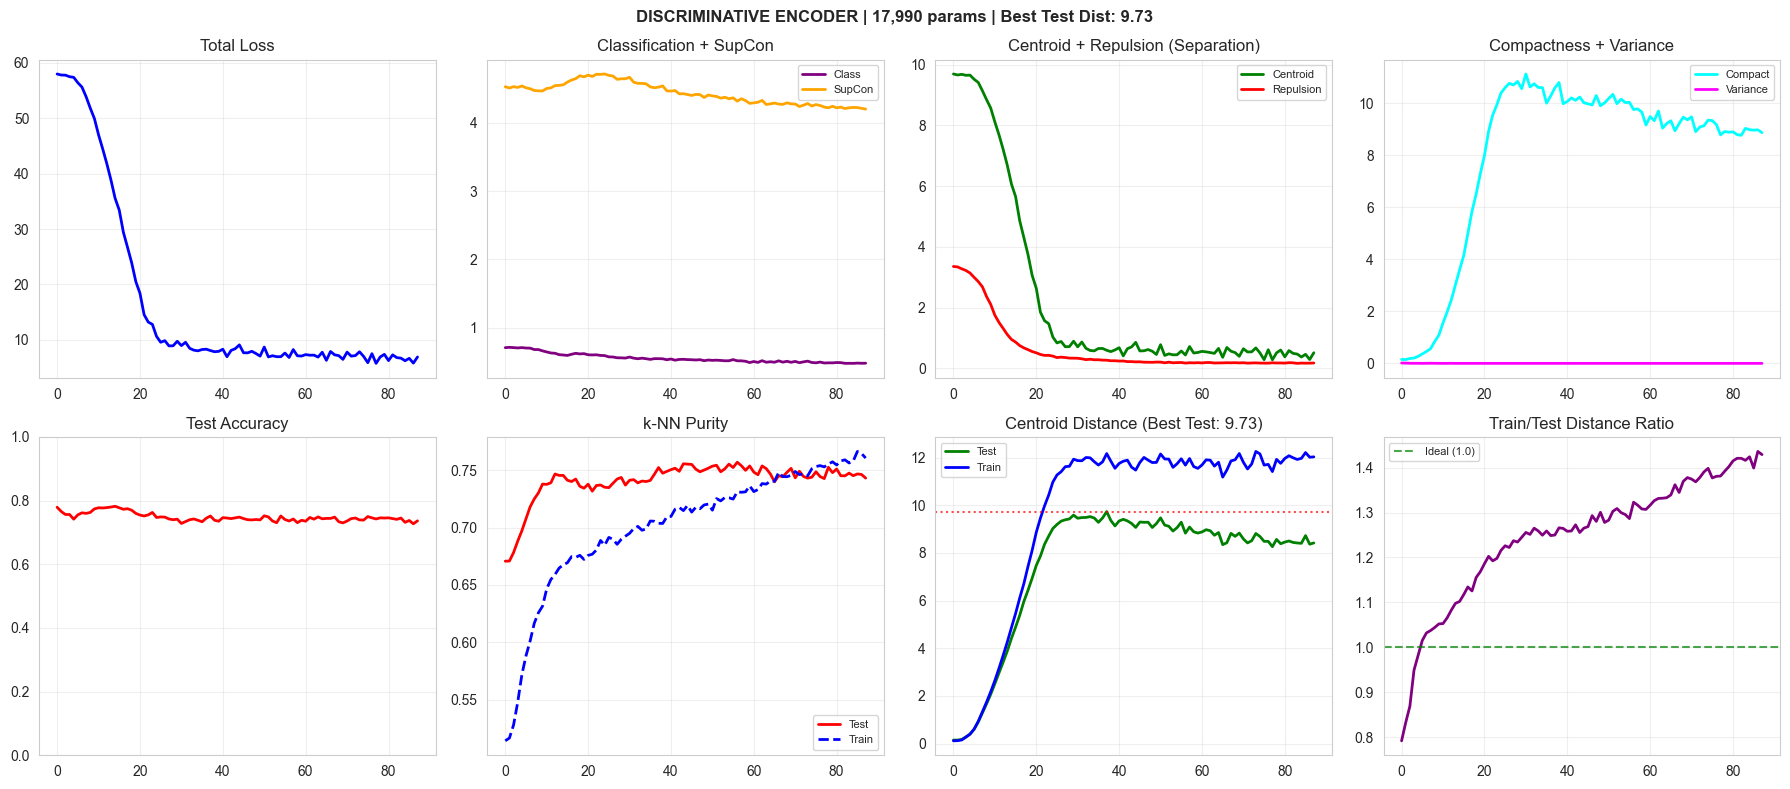

In [25]:
# ============================================================================
# TRAIN DISCRIMINATIVE ENCODER
# ============================================================================
# Key changes from previous attempts:
# 1. NO RECONSTRUCTION - it was fighting class separation
# 2. CLASSIFICATION HEAD - direct supervision signal
# 3. HARD TRIPLET LOSS - focuses on confusing samples
# ============================================================================

# Hyperparameters - OPTIMIZED FOR CLUSTER SEPARATION
LATENT_DIM = 4                # LOW dimension forces discriminative features only
HIDDEN_DIMS = [64, 32]        # Smaller model = less capacity for complex manifolds
DROPOUT = 0.6                 # Higher dropout for regularization
BATCH_SIZE = 64               # Smaller batches = more updates per epoch, smoother training
N_EPOCHS = 500                # More epochs to allow gradual learning
LEARNING_RATE = 0.0005        # LOWER LR for smoother convergence
WEIGHT_DECAY = 0.02           # Stronger weight decay
NOISE_STD = 0.15              # More noise augmentation

# Loss weights - SEPARATION FOCUSED
CLASSIFICATION_WEIGHT = 2.0   # Strong classification signal
SUPCON_WEIGHT = 0.3           # Reduced - can cause curved manifolds
CENTROID_WEIGHT = 5.0         # DOMINANT - push centroids apart
COMPACT_WEIGHT = 0.2          # Reduced - was fighting separation
VARIANCE_WEIGHT = 1.0         # Ensure all dimensions are used
REPULSION_WEIGHT = 2.0        # Direct inter-class repulsion

# Loss parameters
CENTROID_MARGIN = 10.0        # Larger margin = stronger separation
TARGET_RADIUS = 1.5           # Tighter clusters
MIN_VARIANCE = 0.3            # Lower threshold

K_NEIGHBORS = 10

# Early stopping - MORE PATIENT
PATIENCE = 50                 # More patience for gradual improvement
WARMUP_EPOCHS = 30            # Warmup period before early stopping starts

# Prepare data
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.LongTensor(y_train_balanced).to(device)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

# Initialize model
input_dim = X_train_scaled.shape[1]
model = DiscriminativeEncoder(
    input_dim=input_dim, 
    latent_dim=LATENT_DIM, 
    hidden_dims=HIDDEN_DIMS,
    dropout=DROPOUT
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())

print("="*70)
print("TRAINING DISCRIMINATIVE ENCODER")
print("="*70)
print(f"Architecture: {input_dim} -> {HIDDEN_DIMS} -> {LATENT_DIM}D + classifier")
print(f"Dropout: {DROPOUT} | Weight Decay: {WEIGHT_DECAY} | Params: {total_params:,}")
print(f"Train: {len(y_train_balanced)} | Test: {len(y_test)} | Noise: {NOISE_STD}")
print(f"\n⚖️ LOSS WEIGHTS (6 losses - separation focused):")
print(f"   Classification: {CLASSIFICATION_WEIGHT}")
print(f"   SupCon:         {SUPCON_WEIGHT} (reduced)")
print(f"   Centroid:       {CENTROID_WEIGHT} (DOMINANT, margin={CENTROID_MARGIN})")
print(f"   Repulsion:      {REPULSION_WEIGHT} (inter-class push)")
print(f"   Compactness:    {COMPACT_WEIGHT} (reduced)")
print(f"   Variance:       {VARIANCE_WEIGHT} (min={MIN_VARIANCE})")
print(f"\n⚙️ Training schedule:")
print(f"   Warmup: {WARMUP_EPOCHS} epochs (LR: {LEARNING_RATE*0.1:.6f} → {LEARNING_RATE:.6f})")
print(f"   Early stopping patience: {PATIENCE} epochs (after warmup)")

# Optimizer with STRONGER weight decay
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate schedule: warmup + cosine annealing
warmup_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, end_factor=1.0, total_iters=WARMUP_EPOCHS)
main_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS - WARMUP_EPOCHS, eta_min=1e-6)
scheduler = optim.lr_scheduler.SequentialLR(optimizer, schedulers=[warmup_scheduler, main_scheduler], milestones=[WARMUP_EPOCHS])

# Training history (6 losses - separation focused)
history = {'total': [], 'classification': [], 'supcon': [], 
           'centroid': [], 'repulsion': [], 'compact': [], 'variance': [],
           'train_knn_purity': [], 'test_knn_purity': [], 
           'test_acc': [], 'centroid_dist_test': [], 'centroid_dist_train': []}

def compute_test_metrics():
    model.eval()
    with torch.no_grad():
        z_test, logits_test = model(X_test_tensor)
        z_test_np = z_test.cpu().numpy()
        logits_test_np = logits_test.cpu().numpy()
        
        z_train, _ = model(X_train_tensor)
        z_train_np = z_train.cpu().numpy()
        
        # Compute centroid distances
        h_test = z_test_np[y_test == 0].mean(axis=0)
        s_test = z_test_np[y_test == 1].mean(axis=0)
        test_dist = np.linalg.norm(h_test - s_test)
        
        h_train = z_train_np[y_train_balanced == 0].mean(axis=0)
        s_train = z_train_np[y_train_balanced == 1].mean(axis=0)
        train_dist = np.linalg.norm(h_train - s_train)
        
        # k-NN purity
        test_purity = compute_knn_purity(z_test_np, y_test, k=K_NEIGHBORS)
        train_purity = compute_knn_purity(z_train_np, y_train_balanced, k=K_NEIGHBORS)
        
        # Classification accuracy
        preds = logits_test_np.argmax(axis=1)
        acc = (preds == y_test).mean()
        
        return {
            'test_purity': test_purity,
            'train_purity': train_purity,
            'acc': acc,
            'test_dist': test_dist,
            'train_dist': train_dist
        }

print(f"\n[Training with Early Stopping]")
print("-" * 70, flush=True)

train_start = time.time()
best_test_dist = 0
best_epoch = 0
best_test_purity = 0
epochs_without_improvement = 0
best_model_state = None

for epoch in range(N_EPOCHS):
    model.train()
    epoch_losses = {k: 0 for k in ['total', 'classification', 'supcon', 
                                    'centroid', 'repulsion', 'compact', 'variance']}
    
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        
        # Add noise augmentation
        batch_x_aug = batch_x + torch.randn_like(batch_x) * NOISE_STD
        
        z, logits = model(batch_x_aug)
        
        # ============== ALL DISCRIMINATIVE LOSSES ==============
        # 1. Classification Loss
        loss_class = classification_loss(logits, batch_y)
        
        # 2. Supervised Contrastive Loss
        loss_supcon = supervised_contrastive_loss(z, batch_y)
        
        # 3. Margin Centroid Loss (DOMINANT)
        loss_centroid = margin_centroid_loss(z, batch_y, margin=CENTROID_MARGIN)
        
        # 4. Inter-class Repulsion Loss
        loss_repulsion = inter_class_repulsion_loss(z, batch_y, margin=CENTROID_MARGIN/2)
        
        # 5. Compactness Loss (reduced)
        loss_compact = compactness_loss(z, batch_y, target_radius=TARGET_RADIUS)
        
        # 6. Variance Regularization
        loss_var = variance_regularization(z, min_variance=MIN_VARIANCE)
        
        total_loss = (CLASSIFICATION_WEIGHT * loss_class +
                      SUPCON_WEIGHT * loss_supcon +
                      CENTROID_WEIGHT * loss_centroid +
                      REPULSION_WEIGHT * loss_repulsion +
                      COMPACT_WEIGHT * loss_compact +
                      VARIANCE_WEIGHT * loss_var)
        
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        epoch_losses['total'] += total_loss.item()
        epoch_losses['classification'] += loss_class.item()
        epoch_losses['supcon'] += loss_supcon.item()
        epoch_losses['centroid'] += loss_centroid.item()
        epoch_losses['repulsion'] += loss_repulsion.item()
        epoch_losses['compact'] += loss_compact.item()
        epoch_losses['variance'] += loss_var.item()
    
    scheduler.step()
    
    n_batches = len(train_loader)
    for k in epoch_losses.keys():
        history[k].append(epoch_losses[k] / n_batches)
    
    # Compute metrics
    metrics = compute_test_metrics()
    history['test_knn_purity'].append(metrics['test_purity'])
    history['train_knn_purity'].append(metrics['train_purity'])
    history['test_acc'].append(metrics['acc'])
    history['centroid_dist_test'].append(metrics['test_dist'])
    history['centroid_dist_train'].append(metrics['train_dist'])
    
    # Early stopping based on test centroid distance
    if metrics['test_dist'] > best_test_dist:
        best_test_dist = metrics['test_dist']
        best_epoch = epoch + 1
        epochs_without_improvement = 0
        best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    else:
        epochs_without_improvement += 1
    
    if metrics['test_purity'] > best_test_purity:
        best_test_purity = metrics['test_purity']
    
    if (epoch + 1) % 20 == 0 or epoch == 0:
        ratio = metrics['train_dist'] / metrics['test_dist'] if metrics['test_dist'] > 0 else 0
        print(f"  Epoch {epoch+1:3d}/{N_EPOCHS} | "
              f"Acc: {metrics['acc']:.1%} | "
              f"Test Dist: {metrics['test_dist']:.2f} | "
              f"Train Dist: {metrics['train_dist']:.2f} | "
              f"Ratio: {ratio:.2f}x", flush=True)
    
    # Early stopping check (only after warmup period)
    if epoch >= WARMUP_EPOCHS and epochs_without_improvement >= PATIENCE:
        print(f"\n⚠️ Early stopping at epoch {epoch+1} (no improvement for {PATIENCE} epochs after warmup)")
        break

# Restore best model
if best_model_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})
    print(f"✓ Restored best model from epoch {best_epoch}")

train_time = time.time() - train_start
print(f"\n✓ Training completed in {train_time:.2f}s")
print(f"📊 Best TEST centroid distance: {best_test_dist:.2f} (epoch {best_epoch})")
print(f"📊 Best TEST k-NN purity: {best_test_purity:.1%}")
print(f"📊 Final test centroid distance: {history['centroid_dist_test'][-1]:.2f}")
print(f"📊 Final train centroid distance: {history['centroid_dist_train'][-1]:.2f}")
ratio = history['centroid_dist_train'][-1] / history['centroid_dist_test'][-1] if history['centroid_dist_test'][-1] > 0 else 0
print(f"📊 Train/Test ratio: {ratio:.2f}x (lower is better)")

# Plot training - DISCRIMINATIVE ENCODER
fig, axes = plt.subplots(2, 4, figsize=(18, 8))

# Row 1: Losses
axes[0, 0].plot(history['total'], 'b-', linewidth=2)
axes[0, 0].set_title('Total Loss')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history['classification'], 'purple', linewidth=2, label='Class')
axes[0, 1].plot(history['supcon'], 'orange', linewidth=2, label='SupCon')
axes[0, 1].set_title('Classification + SupCon')
axes[0, 1].legend(fontsize=8)
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].plot(history['centroid'], 'green', linewidth=2, label='Centroid')
axes[0, 2].plot(history['repulsion'], 'red', linewidth=2, label='Repulsion')
axes[0, 2].set_title('Centroid + Repulsion (Separation)')
axes[0, 2].legend(fontsize=8)
axes[0, 2].grid(True, alpha=0.3)

axes[0, 3].plot(history['compact'], 'cyan', linewidth=2, label='Compact')
axes[0, 3].plot(history['variance'], 'magenta', linewidth=2, label='Variance')
axes[0, 3].set_title('Compactness + Variance')
axes[0, 3].legend(fontsize=8)
axes[0, 3].grid(True, alpha=0.3)

# Row 2: Metrics
axes[1, 0].plot(history['test_acc'], 'r-', linewidth=2)
axes[1, 0].set_title('Test Accuracy')
axes[1, 0].set_ylim([0.0, 1.0])
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(history['test_knn_purity'], 'r-', linewidth=2, label='Test')
axes[1, 1].plot(history['train_knn_purity'], 'b--', linewidth=2, label='Train')
axes[1, 1].set_title('k-NN Purity')
axes[1, 1].legend(fontsize=8)
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].plot(history['centroid_dist_test'], 'green', linewidth=2, label='Test')
axes[1, 2].plot(history['centroid_dist_train'], 'blue', linewidth=2, label='Train')
axes[1, 2].axhline(y=best_test_dist, color='r', linestyle=':', alpha=0.7)
axes[1, 2].set_title(f'Centroid Distance (Best Test: {best_test_dist:.2f})')
axes[1, 2].legend(fontsize=8)
axes[1, 2].grid(True, alpha=0.3)

# Train/Test ratio
ratios = [t/s if s > 0 else 0 for t, s in zip(history['centroid_dist_train'], history['centroid_dist_test'])]
axes[1, 3].plot(ratios, 'purple', linewidth=2)
axes[1, 3].axhline(y=1.0, color='g', linestyle='--', alpha=0.7, label='Ideal (1.0)')
axes[1, 3].set_title('Train/Test Distance Ratio')
axes[1, 3].legend(fontsize=8)
axes[1, 3].grid(True, alpha=0.3)

plt.suptitle(f'DISCRIMINATIVE ENCODER | {total_params:,} params | Best Test Dist: {best_test_dist:.2f}', 
             fontweight='bold')
plt.tight_layout()
plt.show()


In [26]:
# ============== EXTRACT LATENT REPRESENTATIONS & COMPREHENSIVE METRICS ==============

model.eval()
with torch.no_grad():
    # Get latent representations and logits
    latent_test, logits_test = model(X_test_tensor)
    latent_test_np = latent_test.cpu().numpy()
    logits_test_np = logits_test.cpu().numpy()
    
    latent_train, logits_train = model(X_train_tensor)
    latent_train_np = latent_train.cpu().numpy()
    logits_train_np = logits_train.cpu().numpy()

print("="*60)
print("LATENT REPRESENTATIONS & METRICS")
print("="*60)

# Calculate all metrics
test_metrics = compute_all_metrics(latent_test_np, y_test, logits_test_np)
train_metrics = compute_all_metrics(latent_train_np, y_train_balanced, logits_train_np)

print(f"\n📊 CLASSIFICATION METRICS (TEST):")
print(f"  Accuracy:   {test_metrics['accuracy']:.1%}")
print(f"  F1 Score:   {test_metrics['f1']:.1%}")
print(f"  Precision:  {test_metrics['precision']:.1%}")
print(f"  Recall:     {test_metrics['recall']:.1%}")
print(f"  AUC-ROC:    {test_metrics['auc_roc']:.3f}")

print(f"\n🎯 k-NN PURITY:")
print(f"  Test (k=5):   {test_metrics['knn_purity_5']:.1%}")
print(f"  Test (k=10):  {test_metrics['knn_purity_10']:.1%}")
print(f"  Train (k=10): {train_metrics['knn_purity_10']:.1%}")
gap = train_metrics['knn_purity_10'] - test_metrics['knn_purity_10']
gap_status = "✓ Good" if gap < 0.10 else "⚠️ Overfitting"
print(f"  Gap:          {gap:.1%} {gap_status}")

# Calculate centroids from data (no learned centers in DiscriminativeEncoder)
healthy_cent = latent_test_np[y_test == 0].mean(axis=0)
stroke_cent = latent_test_np[y_test == 1].mean(axis=0)
center_h_str = ", ".join([f"{healthy_cent[i]:.2f}" for i in range(len(healthy_cent))])
center_s_str = ", ".join([f"{stroke_cent[i]:.2f}" for i in range(len(stroke_cent))])
print(f"\n📍 CENTROIDS ({LATENT_DIM}D):")
print(f"  Healthy: [{center_h_str}]")
print(f"  Stroke:  [{center_s_str}]")
center_dist_calc = np.linalg.norm(healthy_cent - stroke_cent)
print(f"  Distance: {center_dist_calc:.2f}")

print(f"\n📈 LINEAR SEPARABILITY:")
print(f"  Test:  {test_metrics['linear_separability']:.1%}")
print(f"  Train: {train_metrics['linear_separability']:.1%}")

# Calculate centroid distances
healthy_test_cent = latent_test_np[y_test == 0].mean(axis=0)
stroke_test_cent = latent_test_np[y_test == 1].mean(axis=0)
test_cent_dist = np.linalg.norm(healthy_test_cent - stroke_test_cent)

healthy_train_cent = latent_train_np[y_train_balanced == 0].mean(axis=0)
stroke_train_cent = latent_train_np[y_train_balanced == 1].mean(axis=0)
train_cent_dist = np.linalg.norm(healthy_train_cent - stroke_train_cent)

print(f"\nCentroid distances:")
print(f"  Test:  {test_cent_dist:.2f}")
print(f"  Train: {train_cent_dist:.2f}")


LATENT REPRESENTATIONS & METRICS

📊 CLASSIFICATION METRICS (TEST):
  Accuracy:   75.2%
  F1 Score:   54.6%
  Precision:  45.1%
  Recall:     69.1%
  AUC-ROC:    0.808

🎯 k-NN PURITY:
  Test (k=5):   75.6%
  Test (k=10):  75.2%
  Train (k=10): 70.4%
  Gap:          -4.9% ✓ Good

📍 CENTROIDS (4D):
  Healthy: [3.58, 2.69, 2.70, 4.17]
  Stroke:  [-1.36, -1.87, -3.33, 0.55]
  Distance: 9.73

📈 LINEAR SEPARABILITY:
  Test:  82.3%
  Train: 80.0%

Centroid distances:
  Test:  9.73
  Train: 12.17


LATENT SPACE VISUALIZATION

Latent dimensions: 4D
Applying UMAP for visualization...


/Users/galle/PycharmProjects/UK-Biobank-Project/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP done!

Centroid distance (test):  9.73
Centroid distance (train): 12.17
Train/Test ratio: 1.25x

Creating UMAP scatter plots...


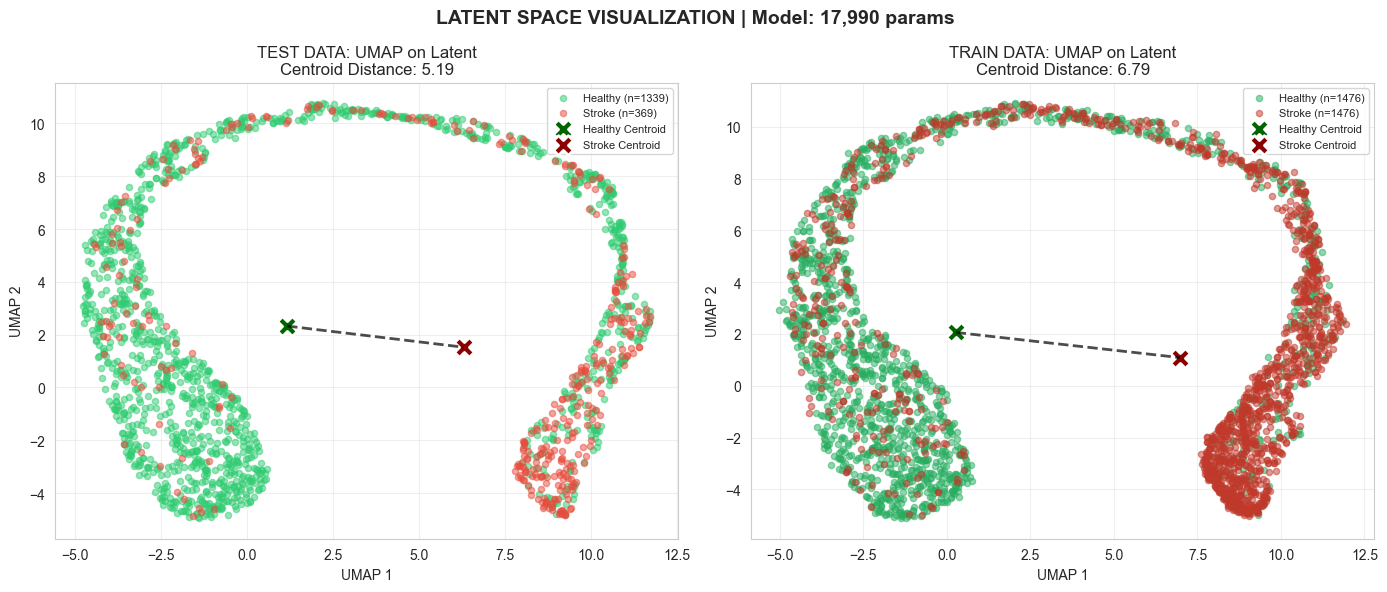


SUMMARY - DISCRIMINATIVE ENCODER
  Latent dimensions: 4D
  Centroid Distance (Test):  9.73
  Centroid Distance (Train): 12.17
  Train/Test Ratio: 1.25x (closer to 1.0 is better)
  UMAP Distance (Test):  5.19
  UMAP Distance (Train): 6.79


In [27]:
# ============== INTERACTIVE VISUALIZATION: 3D UMAP with Plotly ==============

# Install dependencies if needed
try:
    import umap
except ImportError:
    print("Installing umap-learn...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'umap-learn', '-q'])
    import umap

try:
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
except ImportError:
    print("Installing plotly...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'plotly', '-q'])
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots

print("="*70)
print("LATENT SPACE VISUALIZATION")
print("="*70)

# Masks
healthy_mask_test = y_test == 0
healthy_mask_train = y_train_balanced == 0

n_healthy_test = healthy_mask_test.sum()
n_stroke_test = (~healthy_mask_test).sum()
n_healthy_train = healthy_mask_train.sum()
n_stroke_train = (~healthy_mask_train).sum()

print(f"\nLatent dimensions: {latent_test_np.shape[1]}D")
print("Applying UMAP for visualization...")

# ============== APPLY UMAP ==============
umap_reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.3, random_state=42)
latent_test_umap = umap_reducer.fit_transform(latent_test_np)
latent_train_umap = umap_reducer.transform(latent_train_np)
print("UMAP done!")

# ============== CALCULATE METRICS ==============
# Calculate centroids in latent space
h_cent = latent_test_np[healthy_mask_test].mean(axis=0)
s_cent = latent_test_np[~healthy_mask_test].mean(axis=0)
cent_dist_test = np.linalg.norm(h_cent - s_cent)

h_cent_train = latent_train_np[healthy_mask_train].mean(axis=0)
s_cent_train = latent_train_np[~healthy_mask_train].mean(axis=0)
cent_dist_train = np.linalg.norm(h_cent_train - s_cent_train)

# UMAP centroids
h_cent_umap = latent_test_umap[healthy_mask_test].mean(axis=0)
s_cent_umap = latent_test_umap[~healthy_mask_test].mean(axis=0)
cent_dist_umap = np.linalg.norm(h_cent_umap - s_cent_umap)

h_cent_umap_train = latent_train_umap[healthy_mask_train].mean(axis=0)
s_cent_umap_train = latent_train_umap[~healthy_mask_train].mean(axis=0)
cent_dist_umap_train = np.linalg.norm(h_cent_umap_train - s_cent_umap_train)

print(f"\nCentroid distance (test):  {cent_dist_test:.2f}")
print(f"Centroid distance (train): {cent_dist_train:.2f}")
print(f"Train/Test ratio: {cent_dist_train/cent_dist_test:.2f}x")

# ============== UMAP VISUALIZATION ==============
print("\nCreating UMAP scatter plots...")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# TEST DATA - UMAP
ax = axes[0]
ax.scatter(latent_test_umap[healthy_mask_test, 0], latent_test_umap[healthy_mask_test, 1], 
           c='#2ecc71', alpha=0.5, s=20, label=f'Healthy (n={n_healthy_test})')
ax.scatter(latent_test_umap[~healthy_mask_test, 0], latent_test_umap[~healthy_mask_test, 1], 
           c='#e74c3c', alpha=0.5, s=20, label=f'Stroke (n={n_stroke_test})')
ax.scatter(*h_cent_umap, c='darkgreen', s=200, marker='X', edgecolors='white', linewidths=2, label='Healthy Centroid')
ax.scatter(*s_cent_umap, c='darkred', s=200, marker='X', edgecolors='white', linewidths=2, label='Stroke Centroid')
# Draw line between centroids
ax.plot([h_cent_umap[0], s_cent_umap[0]], [h_cent_umap[1], s_cent_umap[1]], 
        'k--', linewidth=2, alpha=0.7)
ax.set_title(f'TEST DATA: UMAP on Latent\nCentroid Distance: {cent_dist_umap:.2f}')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# TRAIN DATA - UMAP
ax = axes[1]
ax.scatter(latent_train_umap[healthy_mask_train, 0], latent_train_umap[healthy_mask_train, 1], 
           c='#27ae60', alpha=0.5, s=20, label=f'Healthy (n={n_healthy_train})')
ax.scatter(latent_train_umap[~healthy_mask_train, 0], latent_train_umap[~healthy_mask_train, 1], 
           c='#c0392b', alpha=0.5, s=20, label=f'Stroke (n={n_stroke_train})')
ax.scatter(*h_cent_umap_train, c='darkgreen', s=200, marker='X', edgecolors='white', linewidths=2, label='Healthy Centroid')
ax.scatter(*s_cent_umap_train, c='darkred', s=200, marker='X', edgecolors='white', linewidths=2, label='Stroke Centroid')
# Draw line between centroids
ax.plot([h_cent_umap_train[0], s_cent_umap_train[0]], [h_cent_umap_train[1], s_cent_umap_train[1]], 
        'k--', linewidth=2, alpha=0.7)
ax.set_title(f'TRAIN DATA: UMAP on Latent\nCentroid Distance: {cent_dist_umap_train:.2f}')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.suptitle(f'LATENT SPACE VISUALIZATION | Model: {total_params:,} params', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

# ============== SUMMARY ==============
print(f"\n{'='*70}")
print("SUMMARY - DISCRIMINATIVE ENCODER")
print(f"{'='*70}")
print(f"  Latent dimensions: {LATENT_DIM}D")
print(f"  Centroid Distance (Test):  {cent_dist_test:.2f}")
print(f"  Centroid Distance (Train): {cent_dist_train:.2f}")
print(f"  Train/Test Ratio: {cent_dist_train/cent_dist_test:.2f}x (closer to 1.0 is better)")
print(f"  UMAP Distance (Test):  {cent_dist_umap:.2f}")
print(f"  UMAP Distance (Train): {cent_dist_umap_train:.2f}")
